In [59]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , merge
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


from keras.layers.merge import dot
from keras.models import Model


# specifically for deeplearning.
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG
 
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
# import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
# from PIL import Image


#TL pecific modules
from keras.applications.vgg16 import VGG16

In [60]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
train = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding = 'latin-1')
train.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [61]:
train.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [62]:
df=train.copy()

In [63]:
df.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [73]:
df.user_id = df.user_id.astype('category').cat.codes.values
df.movie_id = df.movie_id.astype('category').cat.codes.values

In [74]:
df['user_id'].value_counts(ascending=True)

925     20
684     20
165     20
739     20
35      20
887     20
823     20
865     20
557     20
417     20
33      20
630     20
18      20
142     20
894     20
92      20
731     20
474     20
201     20
308     20
571     20
635     20
241     20
595     20
440     20
570     20
146     20
872     20
808     20
299     20
      ... 
795    358
591    360
895    362
416    365
879    368
377    375
434    379
58     382
200    386
221    387
292    388
91     388
307    397
681    399
93     400
6      403
845    405
428    414
278    434
180    435
392    448
233    480
302    484
536    490
415    493
275    518
449    540
12     636
654    685
404    737
Name: user_id, Length: 943, dtype: int64

In [76]:
# creating utility matrix.
index=list(df['user_id'].unique())
columns=list(df['movie_id'].unique())
index=sorted(index)
columns=sorted(columns)
 
util_df=pd.pivot_table(data=df,values='rating',index='user_id',columns='movie_id')
# Nan implies that user has not rated the corressponding movie.

In [79]:
# x_train,x_test,y_train,y_test=train_test_split(df[['userId','movieId']],df[['rating']],test_size=0.20,random_state=42)
users = df.user_id.unique()
movies = df.movie_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [80]:
df['user_id'] = df['user_id'].apply(lambda x: userid2idx[x])
df['movie_id'] = df['movie_id'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]


(80065, 4) (19935, 4)


In [81]:
n_movies=len(df['movie_id'].unique())
n_users=len(df['user_id'].unique())
n_latent_factors=64  # hyperparamter to deal with. 

In [83]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')

In [85]:
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
#user_embedding.shape

In [86]:
user_vec =Flatten(name='FlattenUsers')(user_embedding)
#user_vec.shape

In [88]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
#movie_vec

In [89]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)
model =keras.models.Model([user_input, movie_input],sim)
# #model.summary()
# # A summary of the model is shown below-->

In [90]:
model.compile(optimizer=Adam(lr=1e-4),loss='mse')

Note that the metrics used is 'Mean squared Error'. Our aim is to minimize the mse on the training set ie over the values which the user has rated (100004 ratings).

In [91]:
train.shape
batch_size=128
epochs=50

In [92]:
History = model.fit([train.user_id,train.movie_id],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.user_id,valid.movie_id],valid.rating),
                              verbose = 1)

Train on 80065 samples, validate on 19935 samples
Epoch 1/50
80065/80065 [==============================] - 1s 16us/step - loss: 13.7232 - val_loss: 13.7395
Epoch 2/50
80065/80065 [==============================] - 1s 15us/step - loss: 13.7109 - val_loss: 13.7270
Epoch 3/50
80065/80065 [==============================] - 1s 15us/step - loss: 13.6689 - val_loss: 13.6550
Epoch 4/50
80065/80065 [==============================] - 1s 14us/step - loss: 13.4993 - val_loss: 13.3627
Epoch 5/50
80065/80065 [==============================] - 1s 13us/step - loss: 12.9808 - val_loss: 12.5939
Epoch 6/50
80065/80065 [==============================] - 1s 14us/step - loss: 11.9130 - val_loss: 11.2502
Epoch 7/50
80065/80065 [==============================] - 1s 14us/step - loss: 10.3377 - val_loss: 9.4990
Epoch 8/50
80065/80065 [==============================] - 1s 13us/step - loss: 8.4930 - val_loss: 7.6224
Epoch 9/50
80065/80065 [==============================] - 1s 14us/step - loss: 6.6612 - val_loss:

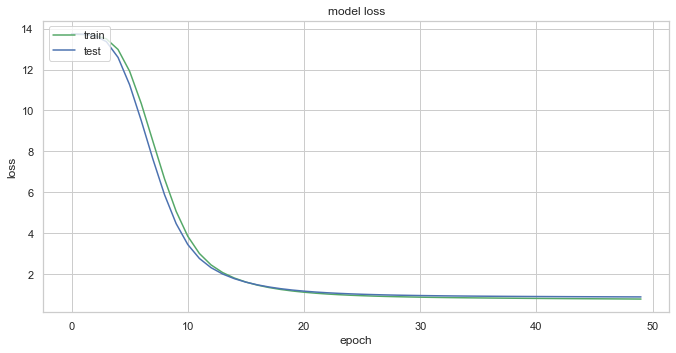

In [93]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [110]:
n_latent_factors=50
n_movies=len(df['movie_id'].unique())
n_users=len(df['user_id'].unique())

In [111]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec=Flatten(name='FlattenUsers')(user_embedding)
user_vec=Dropout(0.40)(user_vec)

In [112]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
movie_vec=Dropout(0.40)(movie_vec)

In [113]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)

In [114]:
nn_inp=Dense(96,activation='relu')(sim)
nn_inp=Dropout(0.4)(nn_inp)
# nn_inp=BatchNormalization()(nn_inp)
nn_inp=Dense(1,activation='relu')(nn_inp)
nn_model =keras.models.Model([user_input, movie_input],nn_inp)
nn_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        47150       user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        84100       movie_input[0][0]                
____________________________________________________________________________________________

In [115]:
nn_model.compile(optimizer=Adam(lr=1e-3),loss='mse')

In [116]:
batch_size=128
epochs=50

In [117]:
History = nn_model.fit([train.user_id,train.movie_id],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.user_id,valid.movie_id],valid.rating),
                              verbose = 1)

Train on 80065 samples, validate on 19935 samples
Epoch 1/50
80065/80065 [==============================] - 2s 20us/step - loss: 3.0847 - val_loss: 1.2794
Epoch 2/50
80065/80065 [==============================] - 1s 16us/step - loss: 1.3078 - val_loss: 1.0830
Epoch 3/50
80065/80065 [==============================] - 1s 15us/step - loss: 1.0961 - val_loss: 0.9972
Epoch 4/50
80065/80065 [==============================] - 1s 15us/step - loss: 0.9852 - val_loss: 0.9554
Epoch 5/50
80065/80065 [==============================] - 1s 14us/step - loss: 0.9323 - val_loss: 0.9371
Epoch 6/50
80065/80065 [==============================] - 1s 15us/step - loss: 0.8953 - val_loss: 0.9290
Epoch 7/50
80065/80065 [==============================] - 1s 15us/step - loss: 0.8564 - val_loss: 0.9229
Epoch 8/50
80065/80065 [==============================] - 1s 17us/step - loss: 0.8235 - val_loss: 0.9128
Epoch 9/50
80065/80065 [==============================] - 1s 17us/step - loss: 0.7983 - val_loss: 0.9122
Epoch